In [17]:
import pandas as pd
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
import random, math
import matplotlib.pyplot as plt

In [18]:
data = pd.read_csv('WPP2019_PopulationByAgeSex_Medium.csv')
rus_data = data[data['Location'] == 'Russian Federation']

AGE_GRPS_DICT = {'0-4':0, '5-9':1, '10-14':2, '15-19':3, '20-24':4, '25-29':5, '30-34':6, '35-39':7, '40-44':8,
 '45-49':9, '50-54':10, '55-59':11, '60-64':12, '65-69':13, '70-74':14, '75-79':15, '80-84':16, '85-89':17,
 '90-94':18, '95-99':19, '100+':20}


# Calculate survival rates over period
def survival_rate(data, period_start = 2000, period_end = 2005):
    format_data = data[data["Time"].isin([period_start, period_end])]

    AgeGrps = format_data.AgeGrp.unique()

    surv_rate_male = []
    surv_rate_fmale = []

    for age in AgeGrps:
        
        if age != '0-4':
            surv_rate_male.append(format_data[(format_data['AgeGrp'] == age) & (format_data['Time'] == period_end)].PopMale.iloc[0] / 
                                format_data[(format_data['AgeGrp'] == prev_age) & (format_data['Time'] == period_start)].PopMale.iloc[0])

            surv_rate_fmale.append(format_data[(format_data['AgeGrp'] == age) & (format_data['Time'] == period_end)].PopFemale.iloc[0] / 
                                format_data[(format_data['AgeGrp'] == prev_age) & (format_data['Time'] == period_start)].PopFemale.iloc[0])
        prev_age = age

    return surv_rate_male, surv_rate_fmale

# Calculate fertility rate
def fertility_rate(data, year, fertilyty_ages):
    format_data = data[(data["Time"] == year)]

    female_pop = format_data[(format_data["Time"]==year) & (format_data["AgeGrp"].isin(fertilyty_ages))].PopFemale.sum()
    born_pop = format_data[(format_data["Time"]==year) & (format_data["AgeGrp"] == '0-4')].PopTotal.sum()

    fert_rate = born_pop/female_pop

    return fert_rate

# Calculate boys/girls ration
def sex_ratio(data, year):
    format_data = data[(data["Time"] == year) & (data["AgeGrp"] == '0-4')]
    sex_ratio = format_data.PopMale.iloc[0] / format_data.PopFemale.iloc[0]
    return sex_ratio


# Population forecast
class Population:
    def __init__(self, pop_data, year, fert_rate, surv_rate_male, surv_rate_fmale, sex_ratio):
        self.pop_data = pop_data
        self.fert_rate = fert_rate
        self.year = year
        self.surv_rate_male = surv_rate_male
        self.surv_rate_fmale = surv_rate_fmale
        self.sex_ratio = sex_ratio

        AgeGrps = rus_data.AgeGrp.unique()
        self.fertilyty_ages = AgeGrps[4:10]

    def simulate_period_constant(self):
        
        # Calculate population movement

        new_pops = self.pop_data[(self.pop_data["Time"] == self.year) & (self.pop_data["AgeGrp"].isin(self.fertilyty_ages))].PopFemale.sum() * self.fert_rate 

        current_pop = self.pop_data[(self.pop_data["Time"] == self.year)].copy()
        current_pop['surv_rate_m'] = [*self.surv_rate_male, 0]
        current_pop['surv_rate_f'] = [*self.surv_rate_fmale, 0]

        for index, row in current_pop.iterrows():
            if row['AgeGrp'] == '0-4':
                current_pop.loc[index, 'PopMale'] = new_pops * (0.5 - (1 - self.sex_ratio))
                current_pop.loc[index, 'PopFemale'] = new_pops * (0.5 + (1 - self.sex_ratio))
            else:
                current_pop.loc[index, 'PopMale'] = prev_row['PopMale'] * prev_row['surv_rate_m']
                current_pop.loc[index, 'PopFemale'] = prev_row['PopFemale'] * prev_row['surv_rate_f']

            current_pop.loc[index, 'PopTotal'] = current_pop.loc[index, 'PopMale'] + current_pop.loc[index, 'PopFemale']

            current_pop.loc[index, 'Time'] += 5
            prev_row = row

        self.pop_data = pd.concat([self.pop_data, current_pop], ignore_index=True) 
        self.year += 5

    def simulate_period_dynamic(self):
        # Culculate population movement
        fertility_range = 4.5

        new_pops = self.pop_data[(self.pop_data["Time"] == self.year) & (self.pop_data["AgeGrp"].isin(self.fertilyty_ages))].PopFemale.sum() * self.fert_rate / fertility_range

        current_pop = self.pop_data[(self.pop_data["Time"] == self.year)].copy()
        current_pop['surv_rate_m'] = [*self.surv_rate_male, 0]
        current_pop['surv_rate_f'] = [*self.surv_rate_fmale, 0]

        for index, row in current_pop.iterrows():
            if row['AgeGrp'] == '0-4':
                current_pop.loc[index, 'PopMale'] = new_pops * (0.5 - (1 - self.sex_ratio))
                current_pop.loc[index, 'PopFemale'] = new_pops * (0.5 + (1 - self.sex_ratio))
            else:
                current_pop.loc[index, 'PopMale'] = prev_row['PopMale'] * prev_row['surv_rate_m']
                current_pop.loc[index, 'PopFemale'] = prev_row['PopFemale'] * prev_row['surv_rate_f']

            current_pop.loc[index, 'PopTotal'] = current_pop.loc[index, 'PopMale'] + current_pop.loc[index, 'PopFemale']

            current_pop.loc[index, 'Time'] += 5
            prev_row = row

        self.pop_data = pd.concat([self.pop_data, current_pop], ignore_index=True)

        # Recalculate coeficients 
        fert_rates = [fertility_rate(self.pop_data, year, self.fertilyty_ages) for year in range(self.year-5, self.year+5, 5)]
        self.fert_rate = sum(fert_rates)/len(fert_rates)

        self.surv_rate_male, self.surv_rate_fmale = survival_rate(self.pop_data, self.year, self.year+5)

        sex_ratios = [sex_ratio(self.pop_data, year) for year in range(self.year-5, self.year+5, 5)]
        self.sex_ratio = sum(sex_ratios)/len(sex_ratios)

        self.year += 5

    def get_total_pop(self, year = None):
        year = self.year if year is None else year
        data = self.pop_data[(self.pop_data["Time"] == year)].copy()
        total_pop = data["PopFemale"].sum() + data["PopMale"].sum()

        return total_pop



In [19]:
# Calculate model input parameters from historical data
AgeGrps = rus_data.AgeGrp.unique()
fertilyty_ages = AgeGrps[4:8]

param_grid = {}

for year in range(1955, 2005, 5):
    param_record = {}

    param_record["pop_data"] = rus_data[rus_data["Time"].isin(list(range(year-5, year+1, 1)))]
    param_record["year"] = year

    fert_rates = [fertility_rate(rus_data, year, fertilyty_ages) for year in range(year-5, year, 1)]
    avg_fert_rate = sum(fert_rates)/len(fert_rates)
    param_record["avg_fert_rate"] = avg_fert_rate

    param_record["surv_rate_male"], param_record["surv_rate_fmale"] = survival_rate(rus_data, year-5, year)

    sex_ratios = [sex_ratio(rus_data, year) for year in range(year-5, year,1)]
    avg_sex_ratio = sum(sex_ratios)/len(sex_ratios)
    param_record["avg_sex_ratio"] = avg_sex_ratio

    param_grid[year] = param_record

#print(param_grid.values())

# Define grid ranges
year_bound = [min(param_grid.keys(), key = lambda key: param_grid[key]["year"]), max(param_grid.keys(), key = lambda key: param_grid[key]["year"])]
fertility_bound = [param_grid[min(param_grid.keys(), key = lambda key: param_grid[key]["avg_fert_rate"])]["avg_fert_rate"], 
                   param_grid[max(param_grid.keys(), key = lambda key: param_grid[key]["avg_fert_rate"])]["avg_fert_rate"]]
sex_ratio_bound = [param_grid[min(param_grid.keys(), key = lambda key: param_grid[key]["avg_sex_ratio"])]["avg_sex_ratio"], 
                   param_grid[max(param_grid.keys(), key = lambda key: param_grid[key]["avg_sex_ratio"])]["avg_sex_ratio"]]

surv_rate_male_bounds = []
surv_rate_fmale_bounds = []

for age_str, age_num in AGE_GRPS_DICT.items():
    if age_str == '100+':
        continue
    
    surv_rate_male_bounds.append([param_grid[min(param_grid.keys(), key = lambda key: param_grid[key]["surv_rate_male"][age_num])]["surv_rate_male"][age_num], 
                            param_grid[max(param_grid.keys(), key = lambda key: param_grid[key]["surv_rate_male"][age_num])]["surv_rate_male"][age_num]])
    surv_rate_fmale_bounds.append([param_grid[min(param_grid.keys(), key = lambda key: param_grid[key]["surv_rate_fmale"][age_num])]["surv_rate_fmale"][age_num], 
                            param_grid[max(param_grid.keys(), key = lambda key: param_grid[key]["surv_rate_fmale"][age_num])]["surv_rate_fmale"][age_num]])

print(year_bound, fertility_bound, sex_ratio_bound, surv_rate_male_bounds, surv_rate_fmale_bounds)

[1955, 2000] [0.31850237819934646, 0.6410716616781762] [1.0277310577222487, 1.0538456700221488] [[0.9564757863931483, 1.0254026321962961], [0.9854262342341975, 1.0243736210977108], [0.9803496629162418, 1.0211490563070043], [0.9718830575213658, 1.0171286866251081], [0.9708655104037495, 1.0082751638824055], [0.9671253447577628, 0.9939346684733467], [0.9386495371447668, 0.981986518524602], [0.9398948759400652, 0.9714643550413753], [0.9408684677249575, 0.9718552827468865], [0.9161458975185361, 0.9470673274592937], [0.8929029263662842, 0.9245737667252271], [0.8488480662830125, 0.8905956702442696], [0.7926860498285582, 0.8296044931040956], [0.7226127718606579, 0.7616345736942536], [0.6369639336095562, 0.6789566659456342], [0.5214584425168722, 0.6420172132304033], [0.3780279221818733, 0.40550980834617784], [0.23748588166664597, 0.2972883753831643], [0.13720606785910663, 0.2018535262206148], [0.08282582216808769, 0.1370913190529876]] [[0.960852899951446, 1.023007286220034], [0.9830524098676091

In [20]:
FORECAST_YEARS = 90

def Evaluate(param_values):
    Y = []
    year = int(2015)
    
    for params in param_values:
        fert_rate, sex_ratio, *surv_rates = params
        surv_rate_male = surv_rates[:20]
        surv_rate_fmale = surv_rates[20:]
        pop_data = rus_data[rus_data["Time"].isin(list(range(year-5, year+1, 1)))]
        rus_pop = Population(pop_data, year, fert_rate, surv_rate_male, surv_rate_fmale, sex_ratio)

        for i in range(int(FORECAST_YEARS / 5 )):
            rus_pop.simulate_period_constant()

        res = rus_pop.get_total_pop()
        Y.append(res)
    return np.array(Y)



## Sensetivity analysis

In [21]:


# Define the model inputs
problem = {
    "num_vars": 42,
    "names": ["fert_rate", "sex_ratio", 
              [str("surv_rate_male_"+key) for key, value in AGE_GRPS_DICT.items() if key != "100+"], 
              [str("surv_rate_fmale_"+key) for key, value in AGE_GRPS_DICT.items() if key != "100+"]],
    "bounds": [fertility_bound, sex_ratio_bound, *surv_rate_male_bounds, *surv_rate_fmale_bounds]
}

param_values = saltelli.sample(problem, 32)

sobol_idx = []

for i in (10, 20, 50, 100):
    
    FORECAST_YEARS = i
    # Generate samples

    Y = Evaluate(param_values)

    # Analyzing
    Si = sobol.analyze(problem, Y, print_to_console=False)

    # Print the first-order sensitivity indices
    print("__________________")
    print(Si["S1"])

    sobol_idx.append({FORECAST_YEARS:Si})




__________________
[ 1.00079269e+00  1.63116347e-04 -8.76795132e-03 -6.96527805e-04
 -3.17741267e-03  3.76905687e-04  2.86214034e-03 -8.83137625e-05
  1.89588368e-02  1.77008072e-03 -4.09101699e-04  9.64870704e-03
  9.40547478e-03  7.05983109e-04  7.86832188e-05 -4.17800786e-04
  4.65100702e-04  2.06911156e-04  1.14239234e-03 -2.05248532e-05
  8.10895256e-06 -7.30153734e-07  1.78744600e-03 -3.32315676e-03
  6.17120673e-04  6.63609787e-04 -5.38589146e-06 -4.42494330e-04
  2.42700981e-03 -6.68281944e-03  4.38237647e-04 -2.37048884e-03
  2.53795586e-04  1.45685716e-03 -6.23904101e-04 -2.11775812e-03
 -1.36638637e-02 -7.02465869e-04 -2.33677891e-04 -2.08943061e-04
 -6.00596476e-05  2.96664515e-06]
__________________
[ 9.90805033e-01  4.15497611e-04 -9.75097394e-03 -1.44238572e-04
 -4.83194001e-03  4.91685164e-04  2.88519778e-03 -3.65699840e-04
  1.51098026e-02  1.95612168e-03 -5.25890854e-04  9.77903400e-03
  8.19565331e-03  3.94450634e-04  9.91333270e-06 -3.52645426e-04
  4.49928907e-04  

[1.000792694200432, 0.00016311634662332001, 0.03205096181300206, -0.022787974384383663]
[0.990805032700216, 0.0004154976105992544, 0.023851851401510388, -0.022038255241272058]
[0.9567136505380955, 0.002329336807972571, 0.00710653593980345, -0.009633635932727683]
[0.8964385867865586, 0.008787965711278038, 0.0012510928240762832, -0.020365570414420255]
    forecast_length             parameter  sobol_s1
0                10             fert_rate  1.000793
1                10             sex_ratio  0.000163
2                10    survival_rate_male  0.032051
3                10  survival_rate_female -0.022788
4                20             fert_rate  0.990805
5                20             sex_ratio  0.000415
6                20    survival_rate_male  0.023852
7                20  survival_rate_female -0.022038
8                50             fert_rate  0.956714
9                50             sex_ratio  0.002329
10               50    survival_rate_male  0.007107
11               50  sur

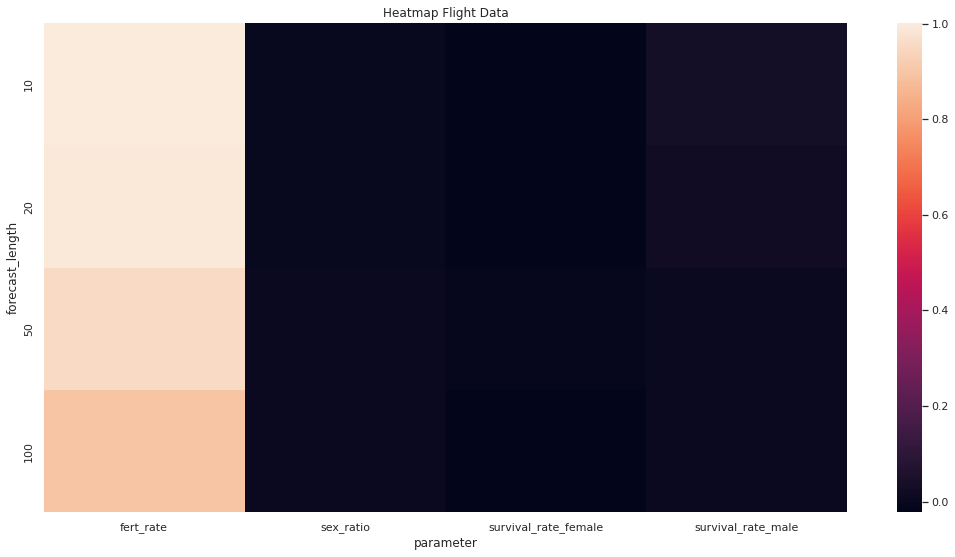

In [38]:
import seaborn as sns
import itertools

heatmap_df = pd.DataFrame()

for item in sobol_idx:

    new_df = pd.DataFrame()

    for key, value in item.items():
        
        
        param_col = ["fert_rate", "sex_ratio", 
              "survival_rate_male", 
              "survival_rate_female"]
        year_col = [key for i in range(len(param_col))]
        sobol_value_col = list(itertools.chain(value["S1"][:2], [sum(value["S1"][2:22])], [sum(value["S1"][22:])]))

        new_df["forecast_length"] = year_col
        new_df["parameter"] = param_col
        print(sobol_value_col)
        new_df["sobol_s1"] = sobol_value_col
     
    heatmap_df = heatmap_df.append(new_df, ignore_index=True)

#heatmap_df["sobol_s1"]=(heatmap_df["sobol_s1"]-heatmap_df["sobol_s1"].min())/(heatmap_df["sobol_s1"].max()-heatmap_df["sobol_s1"].min())
print(heatmap_df)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     print(heatmap_df)

sns.set(rc={'figure.figsize':(18,9)})
heatmap_df_plot = heatmap_df.pivot("forecast_length", "parameter", "sobol_s1")
ax = sns.heatmap(heatmap_df_plot)
plt.title("Heatmap Flight Data")
plt.show()

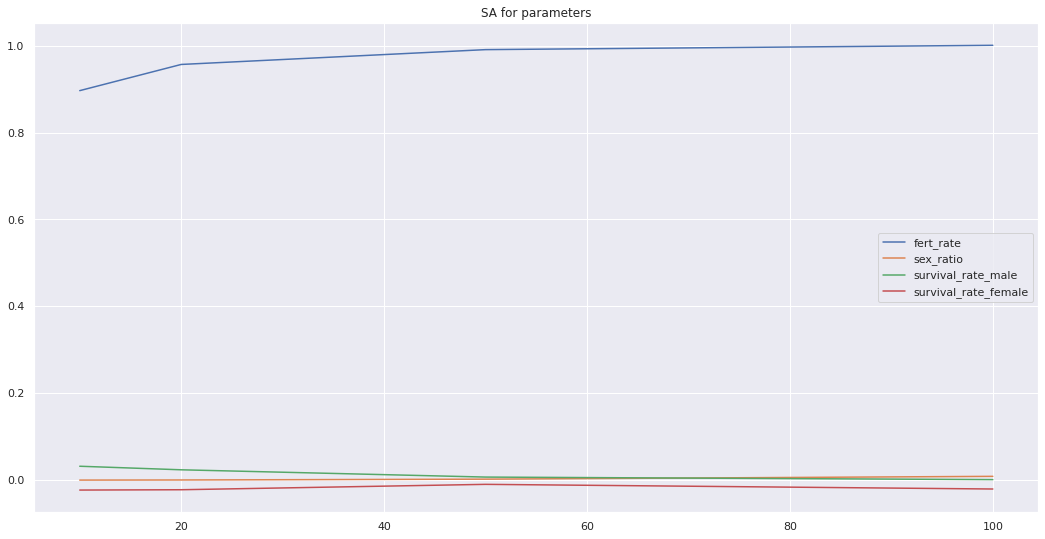

In [44]:

for item in heatmap_df.parameter.unique().tolist():
    plt.plot(heatmap_df[heatmap_df["parameter"] == item]['forecast_length'], heatmap_df[heatmap_df["parameter"] == item]['sobol_s1'], label=f'{item}')

plt.legend(loc = "best")
plt.title("SA for parameters")
plt.show()


## Uncertainty analysis

In [23]:
import statistics

def forecast(param_values, year_end = 2030):
    Y = []
    year_start = int(2015)
    
    for params in param_values:
        res = []

        fert_rate, sex_ratio, *surv_rates = params
        surv_rate_male = surv_rates[:20]
        surv_rate_fmale = surv_rates[20:]
        pop_data = rus_data[rus_data["Time"].isin(list(range(year_start-5, year_start+1, 1)))]
        rus_pop = Population(pop_data, year_start, fert_rate, surv_rate_male, surv_rate_fmale, sex_ratio)

        curr_year = 2015

        while curr_year <= year_end:
            res.append(rus_pop.get_total_pop())

            rus_pop.simulate_period_constant()
            curr_year += 5

        Y.append(res)
    return Y

param_values = saltelli.sample(problem, 32)
forecast_data = forecast(param_values, 2060)

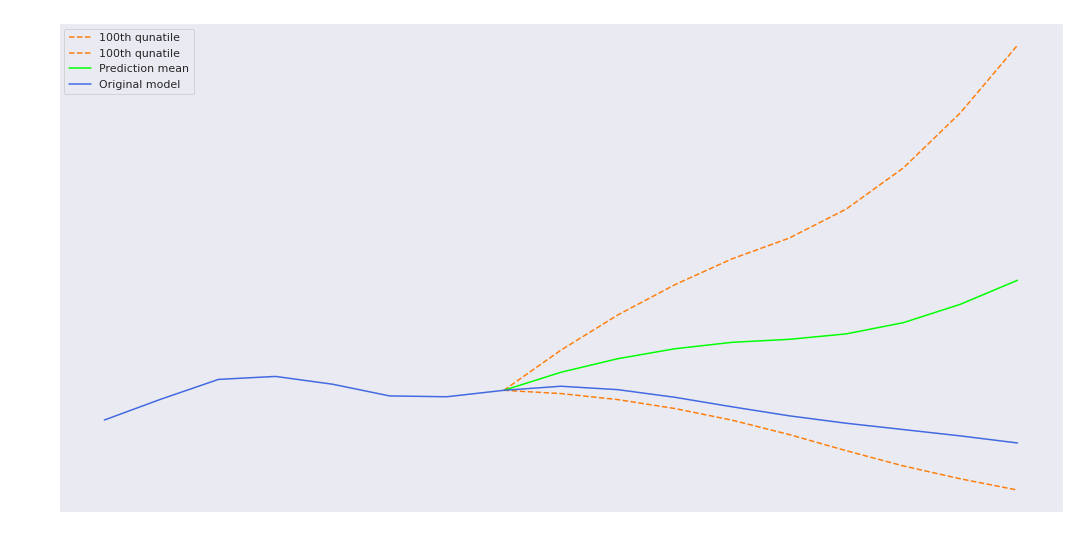

In [27]:
def plot_predict_intervals(forecast_data, year_end, quantile = 100):

    year_start_plot = 1980

    fig = plt.figure(figsize=(18, 9))

    # res_min = [min(idx) for idx in zip(*forecast_data)]
    # res_max = [max(idx) for idx in zip(*forecast_data)]

    res_mean = [statistics.mean(idx) for idx in zip(*forecast_data)]

    quantile_high = [statistics.quantiles(idx, n = 101)[quantile-1] for idx in zip(*forecast_data)]
    quantile_low = [statistics.quantiles(idx, n = 101)[100-quantile] for idx in zip(*forecast_data)]

    # plt.plot(list(range(2015, year_end+5,5)), res_min, linestyle='dashed', color = 'tab:red', label = "Min bound")
    # plt.plot(list(range(2015, year_end+5,5)), res_max, linestyle='dashed', color = 'tab:red', label = "Max bound")


    plt.plot(list(range(2015, year_end+5,5)), quantile_low, linestyle='dashed', color = 'tab:orange', label = f"{quantile}th qunatile")
    plt.plot(list(range(2015, year_end+5,5)), quantile_high, linestyle='dashed', color = 'tab:orange', label = f"{quantile}th qunatile")
    plt.plot(list(range(2015, year_end+5,5)), res_mean, color = "lime", label = "Prediction mean")
    plt.plot(list(range(year_start_plot, year_end+5,5)), rus_data[rus_data["Time"].isin(list(range(year_start_plot, year_end + 5, 5)))].groupby("Time").sum().PopTotal.to_list(), color = "royalblue",label = "Original model")

    plt.title("Forecasts uncertainty", color = 'w')
    plt.grid()
    plt.tick_params( colors='white')
    plt.legend(loc='best')
    plt.show()


plot_predict_intervals(forecast_data, 2060, 100)


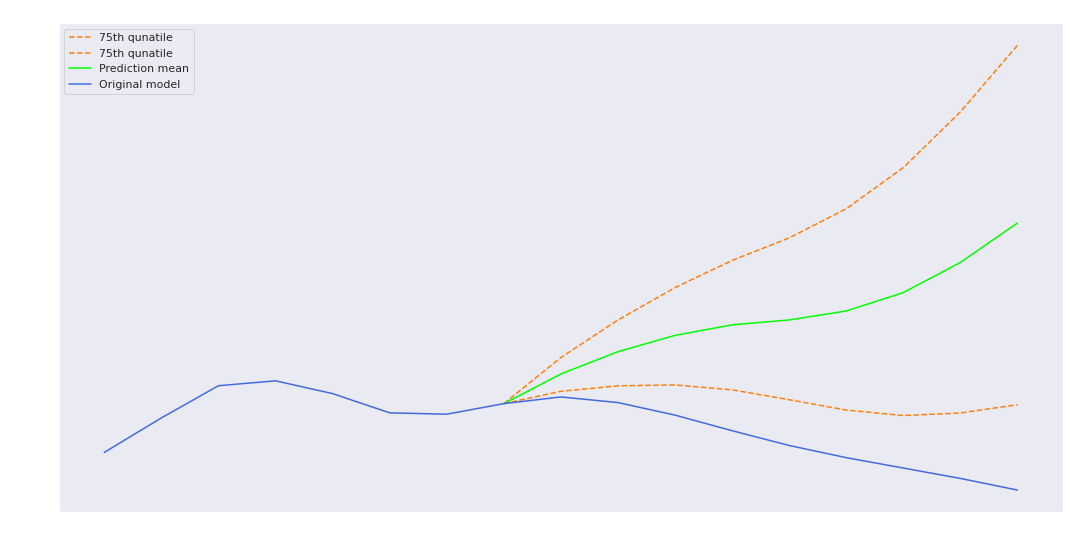

In [28]:
plot_predict_intervals(forecast_data, 2060, 75)